In [0]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [0]:
URL = 'https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-23.csv'

In [6]:
df = pd.read_csv(URL)
df.head()

,index,time_stamp,stop,stopName,number,direction,plannedTime,vehicleId,tripId,status,delay,seq_num
0,1,2018-07-23 06:00:45,378,Os.Piastów,21,Kopiec Wandy,2018-07-23 05:59:00,NaN,6351558574044883205,PLANNED,1,1.0
1,1,2018-07-23 06:00:47,612,Borsucza,22,Walcownia,2018-07-23 06:00:00,6.352185e+18,6351558574044899587,STOPPING,0,7.0
2,1,2018-07-23 06:00:48,572,Smolki,11,Czerwone Maki P+R,2018-07-23 06:00:00,6.352185e+18,6351558574044670211,STOPPING,0,10.0
3,1,2018-07-23 06:00:49,319,Jubilat,1,Wzgórza K.,2018-07-23 05:59:00,NaN,6351558574044363010,PLANNED,1,3.0
4,1,2018-07-23 06:00:49,322,Filharmonia,8,Bronowice Małe,2018-07-23 06:01:00,6.352185e+18,6351558574044592386,STOPPING,0,15.0


In [8]:
df[ df.tripId == 6351558574044883205 ] #sprawdzamy jak wygląda dana trasa

,index,time_stamp,stop,stopName,number,direction,plannedTime,vehicleId,tripId,status,delay,seq_num
0,1,2018-07-23 06:00:45,378,Os.Piastów,21,Kopiec Wandy,2018-07-23 05:59:00,NaN,6351558574044883205,PLANNED,1,1.0
70,3,2018-07-23 06:01:42,379,Piasta Kołodzieja,21,Kopiec Wandy,2018-07-23 06:00:00,NaN,6351558574044883205,PLANNED,1,2.0
135,6,2018-07-23 06:02:46,382,Kleeberga,21,Kopiec Wandy,2018-07-23 06:01:00,NaN,6351558574044883205,PLANNED,1,3.0
284,12,2018-07-23 06:04:54,388,Dunikowskiego,21,Kopiec Wandy,2018-07-23 06:03:00,NaN,6351558574044883205,PLANNED,1,4.0
414,17,2018-07-23 06:06:40,2539,Rondo Hipokratesa,21,Kopiec Wandy,2018-07-23 06:05:00,NaN,6351558574044883205,PLANNED,1,5.0
493,20,2018-07-23 06:07:43,392,DH Wanda,21,Kopiec Wandy,2018-07-23 06:06:00,NaN,6351558574044883205,PLANNED,1,6.0
697,28,2018-07-23 06:10:39,2745,Rondo Kocmyrzowskie im. Ks. Gorzelanego,21,Kopiec Wandy,2018-07-23 06:09:00,NaN,6351558574044883205,PLANNED,1,7.0
772,31,2018-07-23 06:11:43,418,Os.Zgody,21,Kopiec Wandy,2018-07-23 06:10:00,NaN,6351558574044883205,PLANNED,1,8.0
1007,40,2018-07-23 06:14:58,2744,Plac Centralny im. R.Reagana,21,Kopiec Wandy,2018-07-23 06:13:00,NaN,6351558574044883205,PLANNED,1,9.0
1137,45,2018-07-23 06:16:49,423,Struga,21,Kopiec Wandy,2018-07-23 06:15:00,NaN,6351558574044883205,PLANNED,1,10.0


In [11]:
df.delay.value_counts(normalize=True) # sprawdzamy opóźeniania procenotwo

0     0.426905
1     0.344715
2     0.123509
3     0.055987
4     0.025421
5     0.011410
6     0.004852
7     0.002657
8     0.001189
9     0.000867
10    0.000587
14    0.000503
12    0.000475
11    0.000350
13    0.000336
15    0.000154
16    0.000042
19    0.000028
18    0.000014
Name: delay, dtype: float64

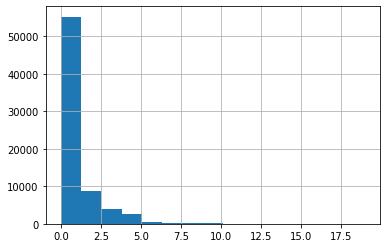

In [18]:
df.delay.hist(bins=15);

In [19]:
df.delay.describe()

count    71517.000000
mean         1.014039
std          1.357324
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         19.000000
Name: delay, dtype: float64

In [21]:
df.columns

Index(['index', 'time_stamp', 'stop', 'stopName', 'number', 'direction',
       'plannedTime', 'vehicleId', 'tripId', 'status', 'delay', 'seq_num'],
      dtype='object')

In [30]:
df['direction'].unique() # sprawdzamy jakie są wartości unikalne dla kierunku

array(['Kopiec Wandy', 'Walcownia', 'Czerwone Maki P+R', 'Wzgórza K.',
       'Bronowice Małe', 'Salwator', 'Mały Płaszów', 'Os.Piastów',
       'Mistrzejowice', 'Bronowice', 'Kurdwanów P+R', 'Nowy Bieżanów P+R',
       'Krowodrza Górka', 'Cichy Kącik', 'Borek Fałęcki', 'Dworzec Tow.',
       'Prokocim', 'Łagiewniki', 'Cm. Rakowicki', 'Kombinat',
       'Plac Centralny im.R.Reagana'], dtype=object)

In [32]:
df['direction'].value_counts() # sprawdzamy w którym kierunku najczęściej jeżdżą tramwaje

Bronowice Małe                 7915
Krowodrza Górka                7140
Czerwone Maki P+R              6771
Nowy Bieżanów P+R              6111
Wzgórza K.                     5236
Borek Fałęcki                  4845
Salwator                       4478
Mistrzejowice                  4381
Kurdwanów P+R                  4010
Os.Piastów                     3973
Kopiec Wandy                   2917
Mały Płaszów                   2862
Bronowice                      2475
Prokocim                       1686
Walcownia                      1648
Cichy Kącik                    1609
Łagiewniki                     1367
Dworzec Tow.                   1161
Cm. Rakowicki                   496
Kombinat                        409
Plac Centralny im.R.Reagana      27
Name: direction, dtype: int64

In [55]:
df['delay_secs'] = df['delay'].map(lambda x: x*60) # przemnażamy wartość przez 60 sekund (w minucie), żeby było po prostu bardziej czytelnie
df['direction_cat'] = df['direction'].factorize()[0] # rzutujemy wartości tekstowe na wartości numeryczne
df['vehicleId'].fillna(-1, inplace=True) # w związku z tym, że niktóry wartości nie wsytepują, są puste, uzupełniamy jakąś wartością unikalną - taką żeby się nie powtórzyła z faktycznymi danymi
df['seq_num'].fillna(-1, inplace=True) # tak samo jak wyżej

df['number_direction_id'] = df.apply(lambda x: '{} {}'.format(x['number'], x['direction']), axis=1).factorize()[0] # łączymy dwie zmienne aby uzyskać unikalne ID i faktoryzujemy jes, gdyż de facto mamy nr tramwaju i nazwę kierunku, a więc string
df['stop_direction_id'] = df.apply(lambda x: '{} {}'.format(x['stop'], x['direction']), axis=1).factorize()[0] # jak wyżej

feats = ['number', 
         'stop', 
         'direction_cat', 
         'vehicleId', 
         'seq_num', 
         # 'number_direction_id', # model lepiej działa bez tego
         # 'stop_direction_id'    # model lepiej działa bez tego
         ]

X = df[ feats ].values # 'number' to lista i przekazujemy ją w formie macierzy, bez podwójnego nawiasu "[]" mielibyśmy wektor (pojedynczą kolumnę)
y = df[ 'delay_secs'].values # tutaj dajemy wektor bo mamy jedynie wartość na ile się spóźnił

model = DecisionTreeRegressor(max_depth=10, random_state=0)
# model = RandomForestRegressor(max_depth=10, n_estimators=50)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error') # "cv" odpowiada za to ile foldów będzie zawierać (na ile część dzieliny nasz zbiór)
np.mean(scores), np.std(scores)

(-48.875873701150844, 2.5311262734011124)

In [0]:
# nasz model myli się o mniej więcej 54 sekundy

In [47]:
df[['plannedTime']].info() # okazuje się że mamy 'object' (string) a chcialibyśmy datę

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71517 entries, 0 to 71516
Data columns (total 1 columns):
plannedTime    71517 non-null object
dtypes: object(1)
memory usage: 558.9+ KB


In [0]:
df[ 'plannedTime' ] = pd.to_datetime( df[ 'plannedTime' ] ) # wyciagamy datę i przypisujemy do tej samej kolumny

In [49]:
df[['plannedTime']].info() # teraz typ mamy jako datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71517 entries, 0 to 71516
Data columns (total 1 columns):
plannedTime    71517 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 558.9 KB


In [53]:
df['plannedTime'].dt.hour.value_counts() # dzięki powyższym operacjom, mozemy wyciagnąć np. miesiąc lub godzinę

17    4673
16    4656
15    4649
8     4644
7     4625
18    4517
9     4382
6     4372
14    4191
19    4088
10    3958
11    3921
13    3917
12    3907
20    3509
21    3183
22    2909
23    1385
0       16
5       15
Name: plannedTime, dtype: int64

In [0]:
df['hour'] = df['plannedTime'].dt.hour.value_counts() # przypisujemy nowe zmienne